In [5]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
from skimage.transform import AffineTransform, warp
from scanpatterns import create_model, test_model_cell, probe_positions, drift_image, rotation_matrix, drift_image_sinus
from transforms import correlation, translate
from ase.io import read

In [2]:
cell = read("Mg2Si.cif").repeat((3,3,1))
m = create_model(cell)

In [3]:
angle1, angle2 = 0, 90
# m, cell = test_model_cell(angle1, extra_space=5)
# m2, cell = test_model_cell(angle2, extra_space=5)

In [70]:
period = 5*m.axes_manager[0].size # m.axes_manager[0].size #line sync
strength = 3 #3 # for line sync

scale = m.axes_manager[-1].scale
drift_direction = np.array([0,1])
drift_vector = 50*drift_direction / (m.axes_manager.signal_size * m.axes_manager[-1].scale / scale)
r1 = rotation_matrix(angle1)
r2 = rotation_matrix(angle2)
drift_vector1 = r1@drift_vector
drift_vector2 = r2@drift_vector

s0a = drift_image_sinus(m,  [0,0], scale=scale, period=period, strength=0)
s0 = drift_image_sinus(m,  [0,0], scale=scale, period=period, strength=strength)
s1 = drift_image_sinus(m,  drift_vector1, scale=scale, period=period, strength=strength)
#s2 = drift_image_sinus(m2, drift_vector2, scale=scale, period=period, strength=strength)
s0.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [71]:
img = s0.data
shape = img.shape
data = img.flatten()

from scipy.ndimage import map_coordinates
def remap(data, coords):
    c = coords[None, :]
    return map_coordinates(data, c, order=5)

coords = np.arange(len(data)) + (-1)*strength*np.sin(2*np.pi*np.arange(len(data))/period)

In [72]:
img_corrected = remap(data, coords).reshape(shape)

fig, AX = plt.subplots(ncols=2, nrows=2, figsize = (8, 8), )
(ax1, ax2, ax3, ax4) = AX.flatten()
ax1.imshow(s0a.data)
ax1.set_title('Pure')
ax2.imshow(img)
ax2.set_title('Added heavy periodic probe noise')
ax3.imshow(img_corrected)
ax3.set_title('Corrected')
ax4.imshow(s0a.data - img_corrected, vmin = -1, vmax = 1)
ax4.set_title('Difference between Corrected and Pure')

for ax in AX.flatten():
    ax.axis('off')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [24]:
#plt.gca().set_title("Line-synced image with strong field")

In [27]:
#s0 = drift_image_sinus(m,  [0,0], scale=scale, period=period, strength=0)
#s1 = drift_image_sinus(m,  [0,0], scale=scale, period=period, strength=strength)

s0.axes_manager[0].scale = 1
s0.axes_manager[1].scale = 1

s1.axes_manager[0].scale = 1
s1.axes_manager[1].scale = 1

hs.plot.plot_images([s0, s1], axes_decor=None, colorbar=False, label=['No distortion', 'With distortion'])
#hs.plot.plot_images([s0, s1, np.log(s0.fft(True, True).amplitude), np.log(s1.fft(True, True).amplitude)], axes_decor=None, vmin=[None, None, 10, 10], per_row=2)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[<AxesSubplot:title={'center':'No distortion'}>,
 <AxesSubplot:title={'center':'With distortion'}>]

In [117]:
Signal1D = hs.signals.Signal1D

In [118]:
data = 

In [124]:
hs.plot.plot_spectra([
    Signal1D(s0.data.flatten()).fft(True).amplitude,
    Signal1D(s1.data.flatten()).fft(True).amplitude,
], legend=('0', '1'))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='<undefined> (<undefined>)', ylabel='Intensity'>

In [101]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

a = s1.fft(True, True)
mask = create_circular_mask(*a.axes_manager.signal_shape, None, 30)
a.data[~mask] = 0
b = a.ifft(True)

In [102]:
hs.plot.plot_images([s0, s1, b], axes_decor=None)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]

In [88]:
b.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [73]:
a = np.log(s1.fft(True, True).amplitude)
a.plot(vmin=10)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]

In [29]:
hs

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

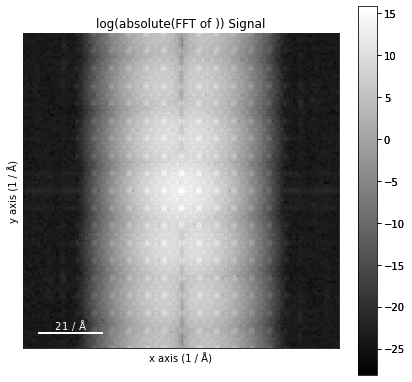

In [17]:
np.log(s1.fft(True).amplitude).plot()

[<AxesSubplot:>, <AxesSubplot:>]

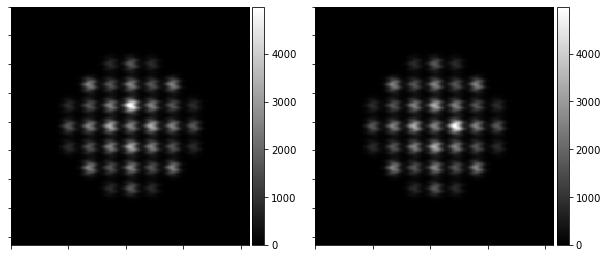

In [7]:
fig = plt.figure(figsize = (10, 5))
hs.plot.plot_images([s1, s2], axes_decor=None, fig=fig)

In [5]:
def transform_back(s, angle, drift_vector):
    img = s.data

    xlen, ylen = s.axes_manager.signal_shape
    b = drift_vector[0] * xlen*ylen
    shear_theta = np.arctan(b/xlen)
    scale = (ylen + drift_vector[1] * xlen*ylen) / ylen
    
    rot_matrix = AffineTransform(rotation = np.deg2rad(-angle))
    shear_matrix = AffineTransform(shear = shear_theta,)
    scale_matrix = AffineTransform(scale = (1, 1/scale))

    shift_x, shift_y = np.array(img.shape) / 2.0
    tf_shift = AffineTransform(translation=[-shift_y, -shift_x])
    tf_shift_inv = AffineTransform(translation=[shift_y, shift_x])
    warped = warp(img,(tf_shift + shear_matrix + scale_matrix + rot_matrix + tf_shift_inv).inverse, order=0,)
    
    return s._deepcopy_with_new_data(warped)

In [59]:
%%timeit
s1._deepcopy_with_new_data(s1.data)

1.64 ms ± 4.21 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
50 / (208*208)

0.0011556952662721894

In [8]:
from scipy.ndimage import fourier_shift
from numpy.fft import fft2, ifft2

In [9]:
strength = 0.0011556952662721894

w1 = transform_back(s1, angle1, strength*r1@drift_direction)#.plot()
w2 = transform_back(s2, angle2, strength*r2@drift_direction)#.plot()

w1, w2 = w1.data, w2.data

c = correlation(w1, w2, "cross", gpu=False)
shift = translate(c, "hybrid", gpu=False)
w2_shift = ifft2(fourier_shift(fft2(w2), shift)).real

In [10]:
np.max(c)

7434763887.440038

In [12]:
%matplotlib widget

In [19]:
plt.figure()
plt.imshow(w1+w2)
plt.axis('off')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(-0.5, 207.5, 207.5, -0.5)

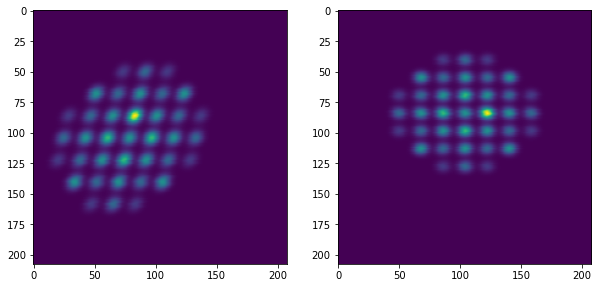

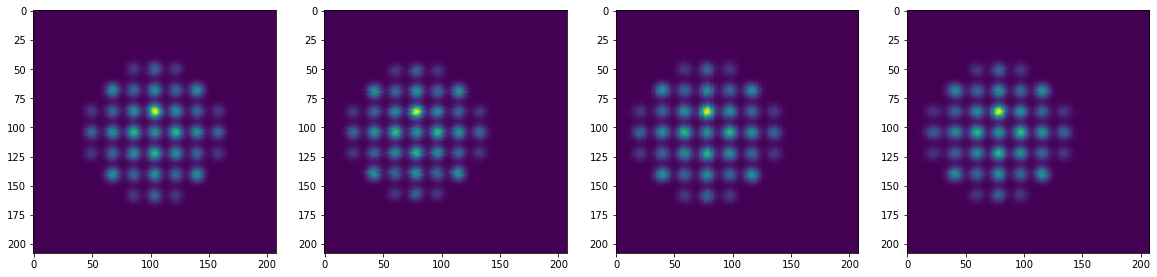

In [11]:
fig, (ax1, ax2, ) = plt.subplots(ncols=2, figsize=(10,5))
ax1.imshow(s1.data)
ax2.imshow(s2.data)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(20,10))
ax1.imshow(s0.data)
ax2.imshow(w1)
ax3.imshow(w2)
ax4.imshow(w1 + w2)